In [1]:
import os
import tensorflow.keras
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import sys
import pickle
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.models import Model
import string
import numpy as np
from pickle import load
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM ,GRU
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout, Reshape, Lambda, Concatenate
from tensorflow.python.keras.layers.merge import add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from nltk.translate.bleu_score import corpus_bleu

embedding_dimension = 50

batch_size = 32

In [2]:
def indicator(value, endvalue, leng=20,job='Job'):

    percent = float(value) / endvalue
    move = '-' * int(round(percent * leng)-1) + '>'
    tab = ' ' * (leng - len(move))

    sys.stdout.write("\r{0} Completion: [{1}] {2}%".format(job,move + tab, int(round(percent * 100))))
    sys.stdout.flush()

In [3]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # taking each line
    for line in doc.split('\n'):
        
        if len(line) < 1:
            continue
        # fetching image id
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return list(set(dataset))

def load_photo_features(filename, dataset):
    
    all_features = load(open(filename, 'rb'))
    
    features = {k: all_features[k] for k in dataset}
    return features

In [4]:
doc = load_doc("Flickr_Data/Flickr_TextData/Flickr8k.token.txt")

In [5]:
descriptions = {}
for line in doc.split('\n'):
    try:
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        # extracting filename
        image_id = image_id.split('.')[0]
        # tokens to string
        image_desc = ' '.join(image_desc)
        if image_id not in descriptions:
            descriptions[image_id] = list()
        descriptions[image_id].append(image_desc)
    except :
        print(line)

1000268201_693b08cb0e ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


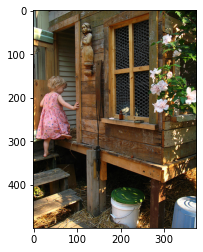

In [6]:
print(next(iter(descriptions)),descriptions[next(iter(descriptions))])

x = plt.imread('Flickr_Data/Images/'+next(iter(descriptions))+'.jpg')
plt.imshow(x)
plt.show()

In [7]:
def clean_data(pairs):
    # removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            
            desc = [word for word in desc if len(word)>0]
            # remove numbers
            desc = [word for word in desc if word.isalpha()]
            # convert into string
            desc_list[i] =  ' '.join(desc)
            
    return descriptions

In [8]:
descriptions_clean = clean_data(descriptions)
descriptions[next(iter(descriptions_clean))]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a girl going into a wooden building',
 'a little girl climbing into a wooden playhouse',
 'a little girl climbing the stairs to her playhouse',
 'a little girl in a pink dress going into a wooden cabin']

In [9]:
start_token = '<startseq>'
end_token = '<endseq>'
def add_end_start_tokens(descriptions):
    for key in descriptions:
        for i in range(len(descriptions[key])):
            descriptions[key][i] = start_token + ' ' + descriptions[key][i] + ' ' + end_token
    return descriptions

In [10]:
tokenss = add_end_start_tokens(descriptions_clean)
tokenss[next(iter(tokenss))]

['<startseq> a child in a pink dress is climbing up a set of stairs in an entry way <endseq>',
 '<startseq> a girl going into a wooden building <endseq>',
 '<startseq> a little girl climbing into a wooden playhouse <endseq>',
 '<startseq> a little girl climbing the stairs to her playhouse <endseq>',
 '<startseq> a little girl in a pink dress going into a wooden cabin <endseq>']

In [11]:
def load_train_test(descriptions, dataset):
    dataset_ = {}
    for image_id in dataset:
        dataset_[image_id] = descriptions[image_id]
        
    return dataset_

In [12]:
train_img_path = 'Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
test_img_path = 'Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'
dev_img_path = 'Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt'

train_img = load_set(train_img_path)
test_img = load_set(test_img_path)
dev_img = load_set(dev_img_path)

len(train_img), len(test_img), len(dev_img)

(6000, 1000, 1000)

In [13]:
train_descriptions = load_train_test(tokenss, train_img)
dev_descriptions = load_train_test(tokenss, dev_img)
test_descriptions = load_train_test(tokenss, test_img)

In [14]:
# making a vocabulary of the words that occur more than count_limit time
def repeating_vocab(descriptions, count_limit = 10):
    # Create a list of all the captions
    sentences = []
    for key, val in descriptions.items():
        for sen in val:
            sentences.append(sen)

    # Consider only words which occur at least 10 times in the corpus
    word_counts = {}
    ncap = 0
    for sent in sentences:
        ncap += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    v = [w for w in word_counts if word_counts[w] >= count_limit]

    return v

In [15]:
vocab = repeating_vocab(train_descriptions, count_limit = 5)
sorted(vocab)[:10]

['<endseq>',
 '<startseq>',
 'a',
 'about',
 'above',
 'accordion',
 'acrobatic',
 'across',
 'act',
 'action']

In [16]:
unknown_token = '<UNK>'
nonalphachar = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n' 
tokenizer = tensorflow.keras.preprocessing.text.Tokenizer(filters = nonalphachar, oov_token=unknown_token)
tokenizer.fit_on_texts(vocab)
vocab_size = len(tokenizer.word_index) + 1
print('vocab_size :', vocab_size)

vocab_size : 2535


In [17]:
ixtoword = {} 
wordtoix = {} 

tokenizer.word_index['<PAD0>'] = 0 # no word in vocab has index 0. but padding is indicated with 0
wordtoix = tokenizer.word_index 

for w in tokenizer.word_index:
    ixtoword[tokenizer.word_index[w]] = w

In [18]:
# finding the maximum length 
def max_length(desc,p):
    all_cap = []
    # Create a list of all the captions
    for i in desc:
        for j in desc[i]:
            all_cap.append(j)

    length_all_cap = list(len(d.split()) for d in all_cap)

    print('percentile {} of len of questions: {}'.format(p,np.percentile(length_all_cap, p)))
    print('longest sentence: ', max(length_all_cap))

    return int(np.percentile(length_all_cap, p))

max_len = max_length(train_descriptions,90)

print('max-len answer for training: ', max_len)

percentile 90 of len of questions: 18.0
longest sentence:  37
max-len answer for training:  18


In [20]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import models

modelVGG16 = VGG16(weights='imagenet')

modelVGG16.layers.pop()
modelVGG16 = models.Model(inputs=modelVGG16.inputs, outputs=modelVGG16.layers[-2].output)
## show the deep learning model

print(modelVGG16.summary())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [25]:
def extract_features(description, model, inpute_size = (224,224)):
    directory = 'Flickr_Data/Images'
    features = {}
    i = 0
    for name in description:
        indicator(value=i,endvalue=len(descriptions))
        i +=1
        filename =os.path.join(directory, name+'.jpg')
        image = load_img(filename, target_size=inpute_size)
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = name.split('.')[0]
        features[image_id] = feature.reshape(4096)
    return features

In [26]:
train_features = extract_features(train_descriptions, modelVGG16)
test_features = extract_features(test_descriptions, modelVGG16)
dev_features = extract_features(dev_descriptions, modelVGG16)

with open('dev_features.pkl','wb') as f:
    pickle.dump(dev_features,f)
with open('train_features.pkl','wb') as f:
    pickle.dump(train_features,f)
with open('test_features.pkl','wb') as f:
    pickle.dump(test_features,f)

Job Completion: [->                  ] 12%

In [28]:
with open('dev_features.pkl','rb') as f:
    dev_features= pickle.load(f)    
with open('train_features.pkl','rb') as f:
    train_features= pickle.load(f)
with open('test_features.pkl','rb') as f:
    test_features= pickle.load(f)

In [29]:

def data_generator(descriptions, photos):
    X1, X2, y = [], [], []
    n=0
    
    while 1:
        for key, value in descriptions.items():
            n+=1
            
            photo = photos[key]
            for cap in value:
                vocab_seq = tokenizer.texts_to_sequences(cap.split())
                for i in range(1, len(vocab_seq)):
                    in_vocab_seq, out_vocab_seq = vocab_seq[:i], vocab_seq[i] 
                    in_vocab_seq = pad_sequences([in_vocab_seq], maxlen=max_length)[0]

                    X1.append(photo)
                    X2.append(in_vocab_seq)
                    y.append(out_vocab_seq)
            if n == batch_size:
                # return the batch data
                yield ([np.array(X1), np.array(X2).squeeze(axis=-1)], np.array(y).squeeze(axis=-1))
                X1, X2, y = list(), list(), list()
                n=0

In [30]:
d = next(data_generator(dev_descriptions, dev_features))
d[0][0].shape, d[0][1].shape, d[1].shape

((1995, 4096), (1995, 18), (1995,))

In [33]:
def glove_layer(embedding_dim=50, glove=True):
    if glove == False:
        print('Null matrix')
        mat = np.zeros((vocab_size, embedding_dim))
    else:
        glove_dir = 'glove'
        index = {} 
        f = open(os.path.join(glove_dir, 'glove.6B.'+str(embedding_dim)+'d.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            strg = np.asarray(values[1:], dtype='float32')
            index[word] = strg
        f.close()
        
        mat = np.zeros((vocab_size, embedding_dim))
        for word, i in wordtoix.items():
            vec = index.get(word)
            if vec is not None:
                
                mat[i] = vec
        print('GloVe loaded!')
        
    l = Embedding(vocab_size, embedding_dim, mask_zero=True, trainable=False)
    l.build((None,))
    l.set_weights([mat])
    
    return l

In [34]:
em_glove_layer = glove_layer(embedding_dimension, glove=True)

GloVe loaded!


In [35]:
def masked_loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = K.sparse_categorical_crossentropy(real, pred, from_logits= False)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [63]:
from keras.layers import RepeatVector
def define_model(embedding ,dout= 0.2, feature_size= 4096, units= 256):
    
    ip1 = Input(shape=(feature_size,))
    ip2 = Dense(units, activation='relu')(ip1) 
    ip3 = RepeatVector(max_length)(ip2)
    ip3 = Dropout(dout)(ip3)
    
    se1 = Input(shape=(max_length,))
    se2 = embedding(se1)
    se2 = Lambda(lambda x: x, output_shape=lambda s:s)(se2) 
    se2 = Dropout(dout)(se2)
    se2 = Concatenate(name='concat_features_word_embeddings', axis=-1)([ip3,se2])
    se2 = LSTM(units, return_sequences=True)(se2)
    se2 = Dropout(dout + 0.2)(se2)
    se2 = LSTM(units, return_sequences=False)(se2)

    outputs = Dense(vocab_size, activation='softmax')(se2)

    # merge the two input models
    model = Model(inputs=[features, seq], outputs = outputs, name='model_with_features_each_step')
    return model

In [64]:
model = define_model(em_glove_layer)
model.summary()

Model: "model_with_features_each_step"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 18)]         0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 256)          1048832     input_8[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 18, 50)       126750      input_9[0][0]                    
______________________________________________________________________

In [65]:
model.compile(loss=masked_loss_function, optimizer= 'adam')

In [66]:
history={'loss':[], 'BLEU_val':[]}

In [67]:
# greedy search
def generator(model, photo_fe, inference= False):
    
    caption = start_token
    
    for i in range(max_length):
        
        s1 = tokenizer.texts_to_sequences(caption.split()) 
        photo_fe = photo_fe.reshape((1,4096))
        s1 = pad_sequences([s1], maxlen=max_length).reshape((1,max_length))
        # predict next word
        pred = model.predict([photo_fe,s1], verbose=0)
        
        # probability
        pred = np.argmax(pred)
        
        word = ixtoword[pred]
        
        if word is None:
            break
        
        caption += ' ' + word
        if word == end_token:
            break
            
    if inference == True:
        caption = caption.split()
        if len(caption) == max_length:
            caption = caption[1:] # if it is already at max len and endseq hasn't appeared
        else:
            caption = caption[1:-1]
        caption = ' '.join(caption)
        
    return caption

In [68]:
def beam_search_pred(model, pic_fe, wordtoix, K_beams = 3, log = False):
    start = [wordtoix[start_token]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            sequence  = pad_sequences([s[0]], maxlen=max_length).reshape((1,max_length)) 
            preds = model.predict([pic_fe.reshape(1,4096), sequence])
            word_preds = np.argsort(preds[0])[-K_beams:] 
            for w in word_preds:
                
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w]) 
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])
        start_word = temp
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])

        start_word = start_word[-K_beams:]
    
    start_word = start_word[-1][0]
    captions_ = [ixtoword[i] for i in start_word]

    final_caption = []
    
    for i in captions_:
        if i != end_token:
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [69]:
# calculating BLEU score of predictions
def get_bleu_score(model, descriptions, photos_fe, K_beams= 3, log=False):
    actual, predicted = list(), list()
    i=0
    for key, desc_list in descriptions.items():
        
        i+=1
        indicator(i, len(descriptions), leng=20,job='Evaluating')
        if K_beams == 1:
            yhat = generator(model, photos_fe[key])
        else:
            yhat=beam_search_pred(model, photos_fe[key], wordtoix, K_beams = K_beams,log=log)
        
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
        
   
    b1=corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    b2=corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    b3=corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    b4=corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    print('\n')
    print('BLEU-1: %f' % b1)
    print('BLEU-2: %f' % b2)
    print('BLEU-3: %f' % b3)
    print('BLEU-4: %f' % b4)
    return [b1,b2,b3,b4]

In [70]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
Reduce_lr= ReduceLROnPlateau(monitor='loss', factor=0.9, patience=5, verbose=0, mode='auto', min_delta=0.0001, min_lr=0.000001)

In [72]:
steps = len(train_descriptions)//batch_size

In [73]:
# create the data generator
generator = data_generator(train_descriptions, train_features)

In [75]:
ep=1
for i in range(ep, 21):
    
    print('Epoch :',i,'\n')
    # fit for one epoch
    h = model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[Reduce_lr] )
    ep = i + 1
    history['loss'].append(h.history['loss'])
    
    # save model every 3 epochs
    if i % 3 == 0:
        test() 
        model.save('Models'+'/model_' + str(i) + '.h5')
        belus= get_bleu_score(model, dev_descriptions, dev_features, K_beams=1)    
        history['BLEU_val'].append((belus,i))

    print('\n','='*80)

Epoch : 1 



C:\Users\kchit\anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


187/187 [==============================] - 143s 686ms/step - loss: 5.1633

Epoch : 2 

187/187 [==============================] - 150s 800ms/step - loss: 4.8151

Epoch : 3 

187/187 [==============================] - 152s 812ms/step - loss: 4.4878
====
Greedy: a man is in a <UNK>
Greedy: a man is in a <UNK>
Greedy: a man is in a <UNK>
Greedy: a man is in a <UNK>
====
Evaluating Completion: [------------------->] 100%

BLEU-1: 0.593684
BLEU-2: 0.352788
BLEU-3: 0.207346
BLEU-4: 0.088237

Epoch : 4 

187/187 [==============================] - 59s 318ms/step - loss: 4.0747

Epoch : 5 

187/187 [==============================] - 60s 318ms/step - loss: 3.8181

Epoch : 6 

187/187 [==============================] - 59s 317ms/step - loss: 3.6638
====
Greedy: a man in a red shirt is standing on a <UNK>
Greedy: a man in a red shirt is standing on a skateboard
Greedy: a man in a red shirt is standing on a <UNK>
Greedy: a man in a red shirt is standing on a <UNK>
====
Evaluating Completion: [-----

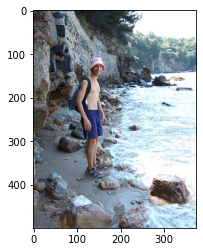

Greedy: a man in a red shirt and a backpack is standing on a rock overlooking a large
Beam K= 3: a group of people sit on a rock overlooking the ocean
Beam K= 5: a group of people sit on a rock overlooking the ocean
Beam log K= 3: a man in a blue shirt is standing on top of a rock overlooking the ocean
Beam log K= 5: a group of people are standing on a rock overlooking the ocean


In [86]:
pic = list(test_features.keys())[501]
fe = test_features[pic].reshape((1,4096))
x=plt.imread('Flickr_Data/Images/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generator(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=True))